In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
#from torch.distributions import Gamma
#torch.manual_seed(1)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib import gridspec

import numpy as np

from scipy import signal # for convolution
import scipy.stats as stats
import scipy.special as sps

import pickle

import sys
sys.path.append("../..")

from neuroprob.utils import stats, tools, neural_utils
import neuroprob.models as mdl


dev = tools.PyTorch()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.6.0+cu101
Using device: cuda:0


### Data loading

In [2]:
sample_bin, track_samples, x_t, y_t, s_t, dir_t, hd_t, eeg_t, theta_t, \
    hilbert_amp, hilbert_theta, pause_ind, pause_size, \
    sep_t_spike, clu_id, t_spike, spike_samples, units, \
    shank_id, local_clu, FR_waveshape, SpkWidthC, \
    refract_viol, sess_avg_rate, isolation_dist, LV, ISI, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('./saves/datasets/hc5_13.p', 'rb'))

max_speed = s_t.max()
wrap_theta_t = tools.WrapPi(theta_t, True)
behav_data = (x_t, y_t, wrap_theta_t)

In [2]:
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    sep_t_spike, spike_samples, units, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('./saves/synthetic/gauss_pop_IPP.p', 'rb'))

max_speed = s_t.max()
wrap_theta_t = tools.WrapPi(theta_t, True)
behav_data = (x_t, y_t, wrap_theta_t)

In [2]:
sample_bin, track_samples, behav_data, \
            sep_t_spike, units, \
            left_x, right_x, bottom_y, top_y = pickle.load(open('./saves/synthetic/grid_IPP.p', 'rb'))

In [3]:
arena_width = right_x - left_x
arena_height = top_y - bottom_y

In [4]:
neurons = np.arange(units)#[30]#
used_t_spike = [sep_t_spike[n] for n in neurons]
units_used = len(neurons)
unit_used = np.arange(units_used)
show_neurons = [0, 1, 2, 3, 4]


bin_size = 1
tbin, resamples, rc_t, (rx_t, ry_t, rtheta_t) = neural_utils.BinTrain(bin_size, sample_bin, used_t_spike, 
                                                                    track_samples, behav_data)

### Conditional GPLVM

In [ ]:
# GPLVM
units_ = neurons
l = np.ones(units_)
v = np.ones(units_)
kernels_tuples = [('RBF', 'euclid', np.array([l, l]), v), 
                  ('RBF', 'torus', np.array([l]), v)]
prior_tuple = [('Normal', 'euclid', 0.0, 1.0, False, False), 
               ('Normal', 'euclid', 0.0, 1.0, False, False), 
               ('Uniform', 'torus', 0.0, 1.0, False, False)]
variational_types = [('Normal', 'euclid'), 
                     ('Normal', 'euclid'), 
                     ('Normal', 'torus')]

num_induc = 16
inducing_points = np.array([left_x + arena_width*np.random.rand(num_induc), \
                            bottom_y + arena_height*np.random.rand(num_induc), \
                            np.linspace(0, 2*np.pi, num_induc+1)[:-1]]).T[None, ...].repeat(units_used, axis=0)

gp_lvm = mdl.nonparametrics.GP_covariates(units_used, inducing_points, kernels_tuples, 
                                          prior_tuple, variational_types, jitter=1e-4,
                                          shared_kernel_params=False, full_cov_fit=False)
gp_lvm.set_params(tbin)


renewal_dist = mdl.likelihoods.Poisson(units_used, 'exp')
renewal_dist.set_params(tbin)

# NLL model
glm = mdl.inference.nll_optimized(gp_lvm, renewal_dist)

In [ ]:
# preprocessing
rx_t = rbehav_t[0]
ry_t = rbehav_t[1]
rtheta_t = rbehav_t[2]

ini_X = [rx_t, ry_t, np.random.rand(resamples, 2)*2*np.pi]
ini_X[2][:, 1].fill(0.0) # f^-1 std of variational distribution

glm.preprocess(ini_X, resamples, rc_t, batch_size=10000)
glm.to(dev)

sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 5*1e-2}
glm.set_optimizers(opt_tuple, opt_lr_dict)

In [ ]:
# fitting
annealing = lambda x: min(1.0, 0.005*x)
losses = glm.fit(10000, margin=1e0, premature=100, anneal_func=annealing, 
                 cov_samples=16, ll_samples=1)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

In [ ]:
X_loc, X_std = gp_lvm.eval_X()
T = 10000

# model trajectory
plt.scatter(X_loc[0][:T], X_loc[1][:T], marker='.')
plt.show()

plt.scatter(np.arange(T), X_loc[2][:T] % (2*np.pi), marker='.')
plt.show()

### GLM decoding

In [ ]:
# Gaussian
mu = np.array([[250., 250.], [100., 100.], [400., 300.], [50., 350.], [360., 70.]])
prec = np.array([[0.0001, 0.0001, 0.00005], [0.0002, 0.0002, 0.0], [0.0001, 0.0002, 0.00005], 
                 [0.0001, 0.0002, 0.0], [0.00015, 0.00015, 0.0]])
rate_0 = np.array([8.0, 20.0, 10.0, 17.0, 12.0]) # Hz
t_p = np.array([[0.0, 0.0], [1.0, 0.2], [0.5, 0.0], [0.7, 1.0], [0.1, 0.0]]) # beta, phi_0 for theta modulation

glm_rate = mdl.gaussian.Gauss_GLM(units_used, 'exp')
w = glm_rate.gaussian_to_w(mu, prec, rate_0)
glm_rate.set_params(sample_bin, w)

shape = np.ones(units_used)
renewal_dist = mdl.renewal.Gamma(units_used, 'exp', shape)
renewal_dist.set_params(sample_bin)

In [ ]:
# NLL model
glm = mdl.inference.nll_optimized(glm_rate, renewal_dist)
glm.to(dev)

# check the NLL of model over all data with initialized parameters
glm.preprocess(behav_data, rc_t, batch_size=track_samples)
print(glm.nll(0).item())

In [ ]:
# fitting (regression)
glm.preprocess(behav_data, None, rc_t, batch_size=100000)

sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 10, sch)
opt_lr_dict = {'default': 1e-1}
glm.set_optimizers(opt_tuple, opt_lr_dict)

losses = glm.fit(1000, cov_samples=1)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

In [ ]:
# decoding (regression)
ini_X = np.random.rand(2, 2, 10000)#resamples)
ini_X[0, 0, :] = x_t[:10000]
ini_X[0, 1, :] = y_t[:10000]
ini_X[1, ...].fill(0.0)

glm.preprocess(None, ini_X, rc_t, batch_size=100000)

sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 10, sch)
opt_lr_dict = {'default': 0}
glm.set_optimizers(opt_tuple, opt_lr_dict)

losses = glm.fit(1000, cov_samples=1)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

### Particle filter

In [3]:
# synthetic grid field data


bin_size = 10
tbin, resamples, rc_t, (rx_t, ry_t, rtheta_t) = neural_utils.BinTrain(bin_size, sample_bin, syn_t_spike, 
                                                                    steps, behav_data)

eval_rate = []
for neuron in range(neurons):
    def func(cov):
        return glm_rate.eval_rate(cov, [neuron])[0]
    eval_rate.append(func)

NameError: name 'sample_bin' is not defined

In [65]:
# use real data and fitted model for the particle filter
bin_size = 10
tbin, resamples, rc_t, (rx_t, ry_t, rtheta_t) = neural_utils.BinTrain(bin_size, sample_bin, sep_t_spike, 
                                                                    track_samples, behav_data)

eval_rate = []
for neuron in range(units_used):
    func = lambda f: glm_rate.eval_rate(f, neuron=neuron)
    eval_rate.append(func)

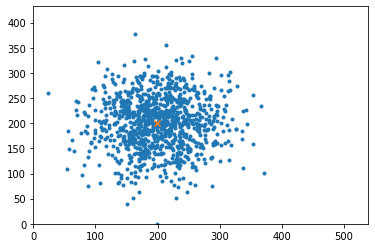

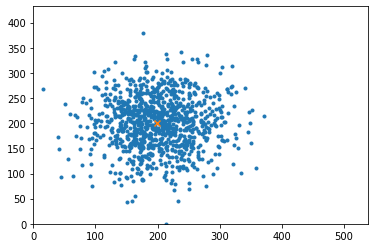

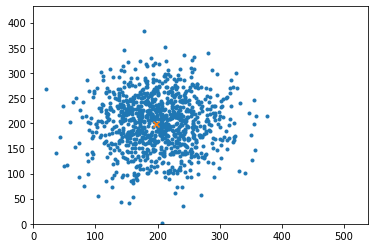

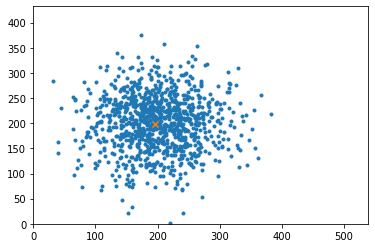

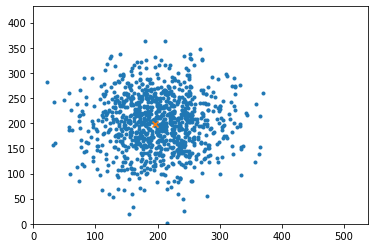

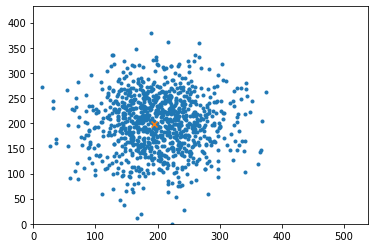

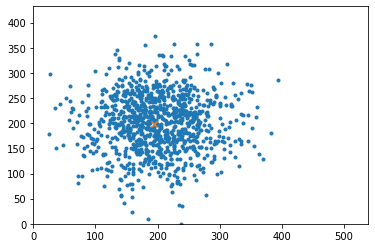

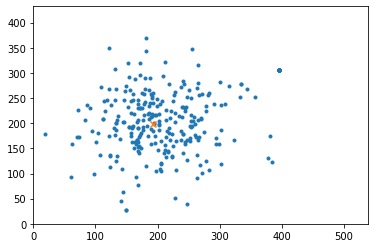

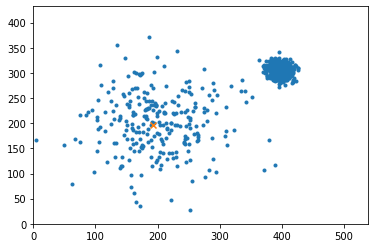

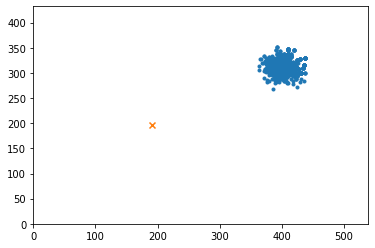

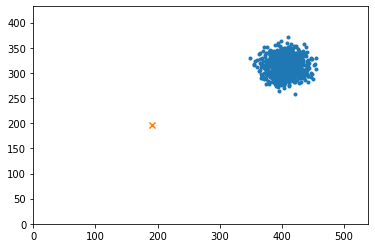

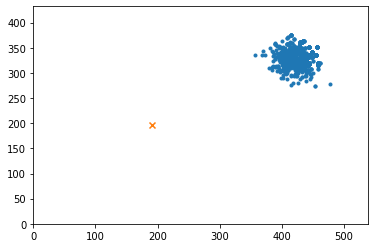

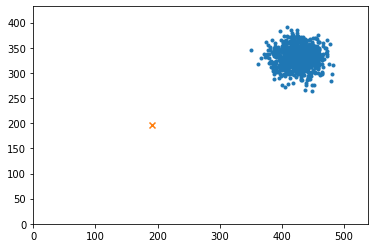

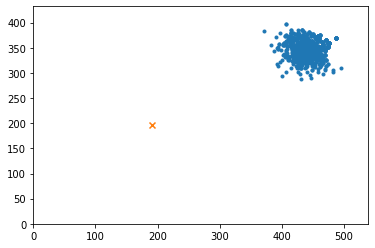

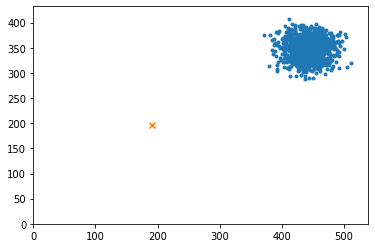

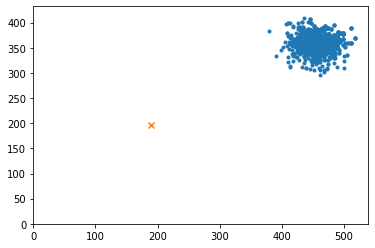

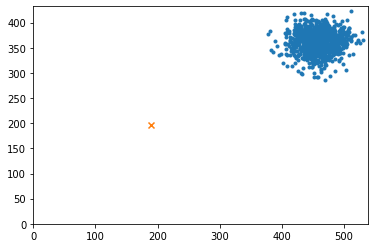

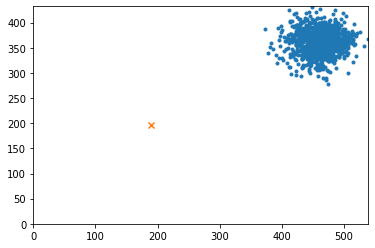

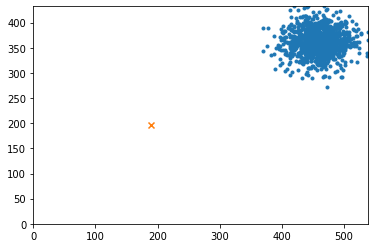

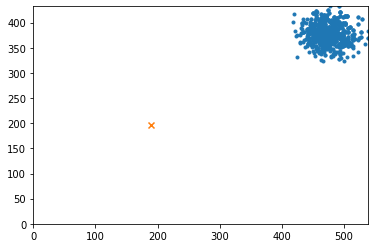

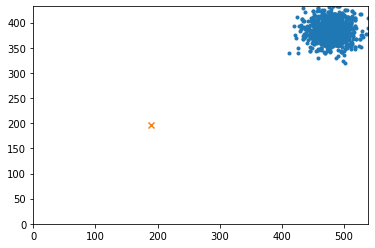

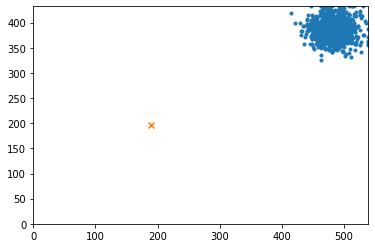

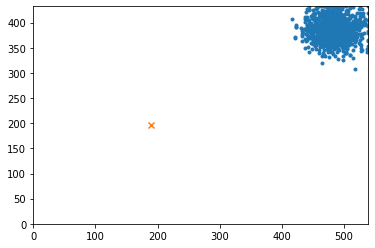

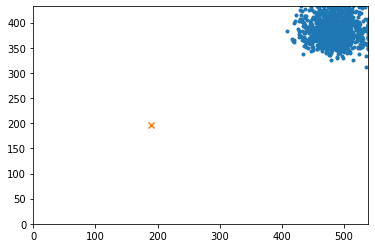

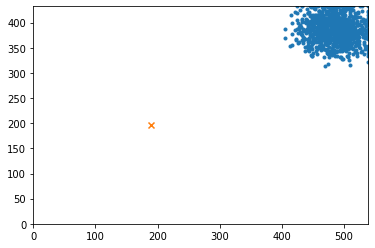

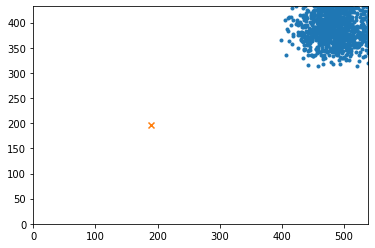

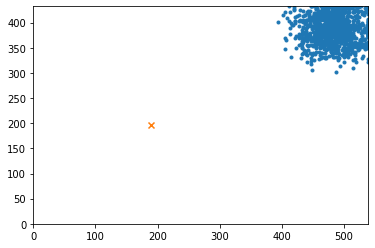

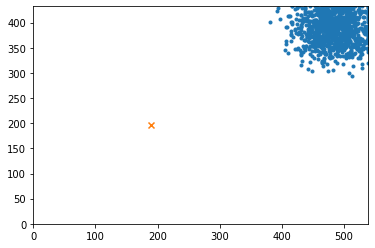

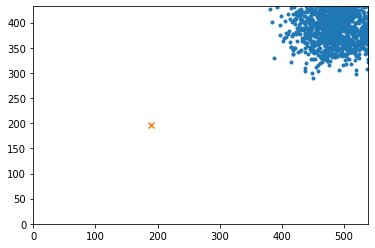

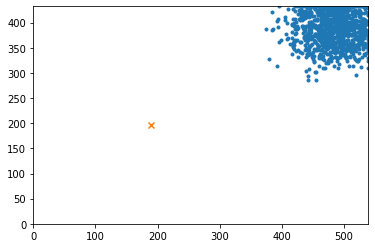

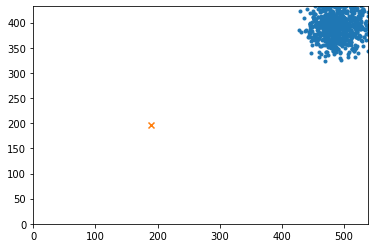

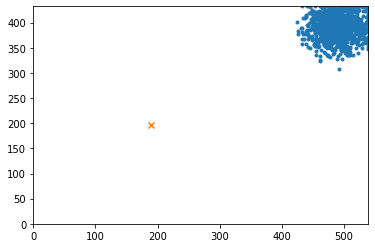

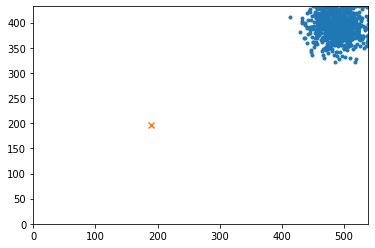

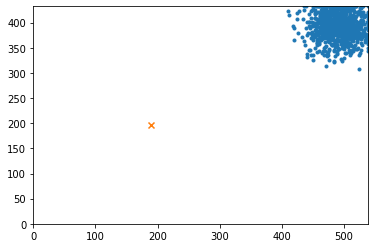

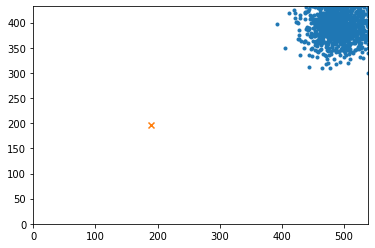

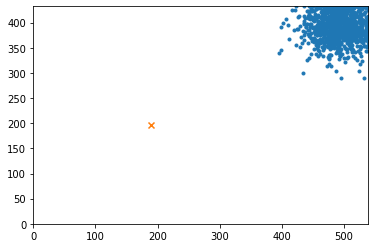

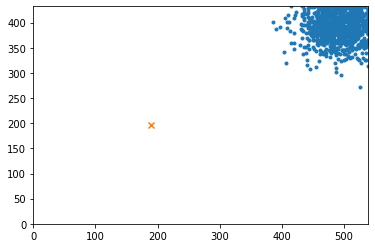

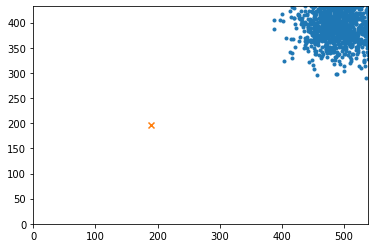

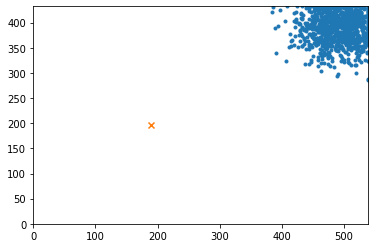

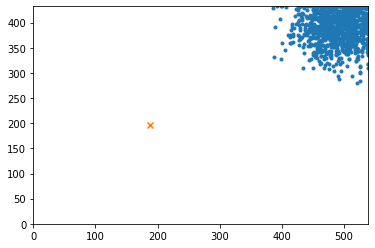

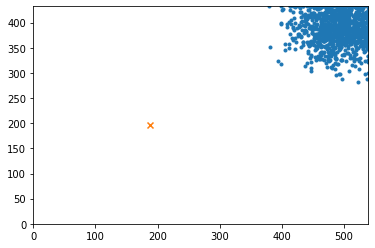

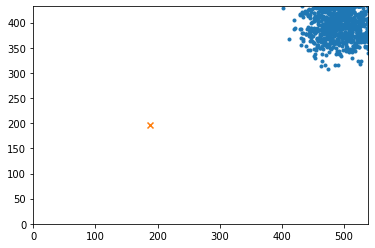

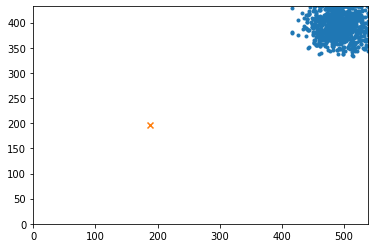

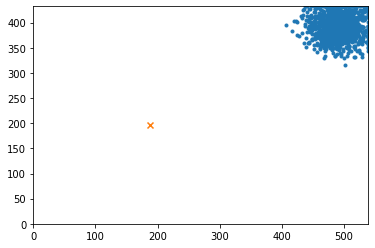

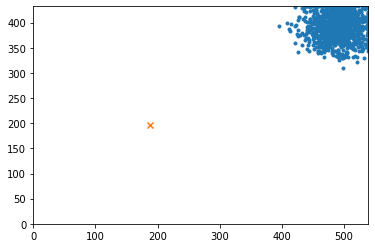

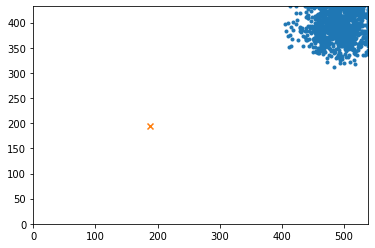

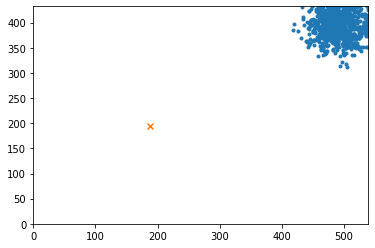

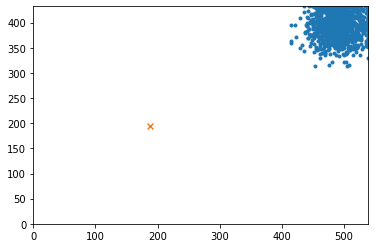

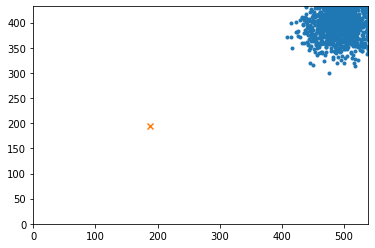

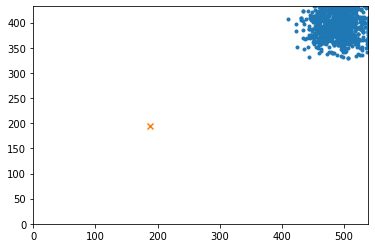

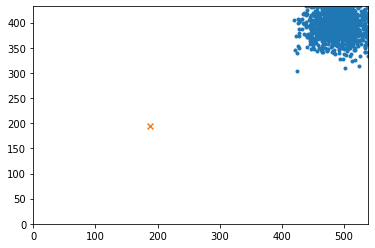

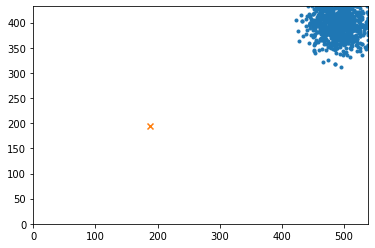

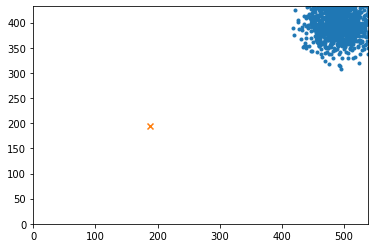

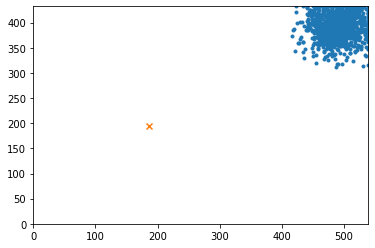

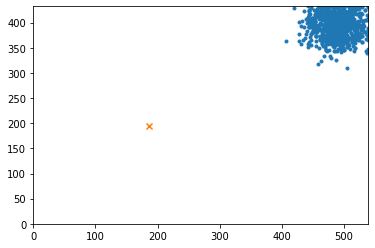

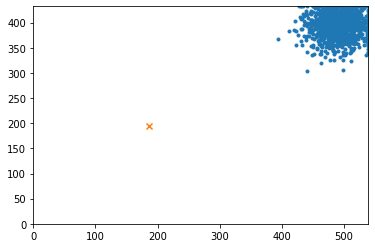

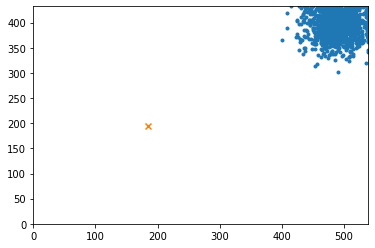

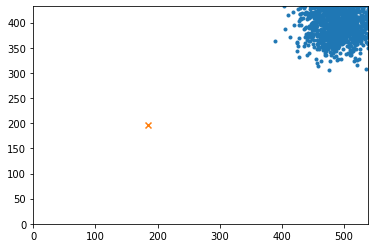

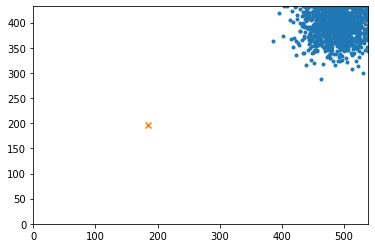

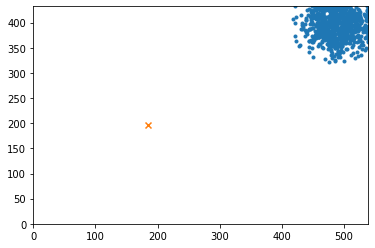

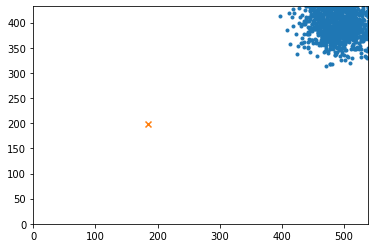

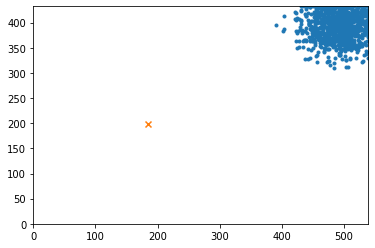

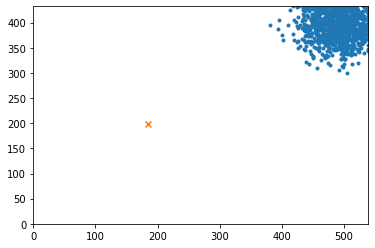

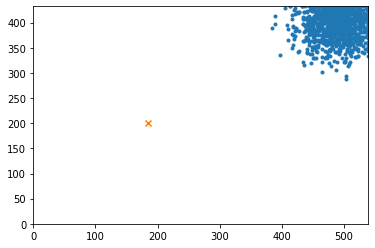

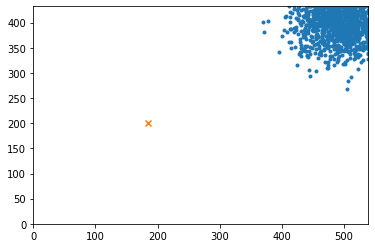

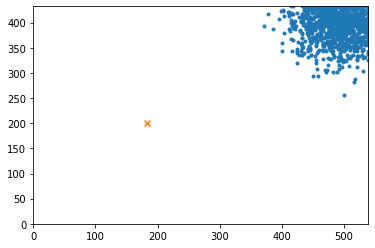

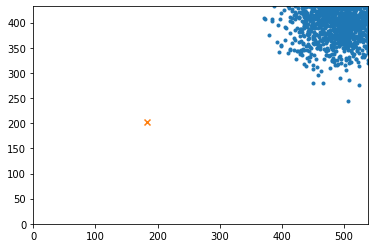

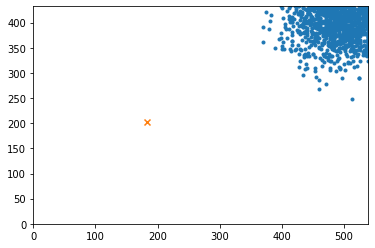

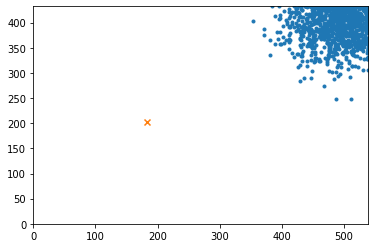

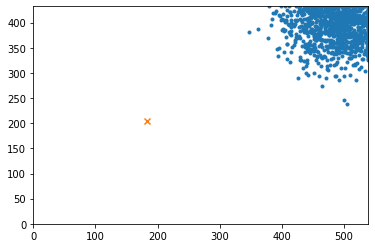

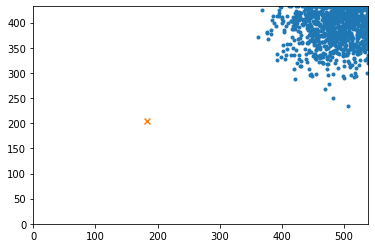

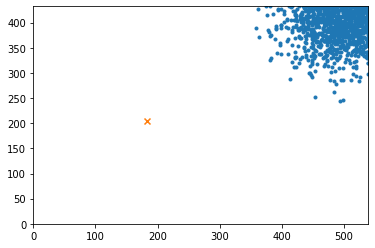

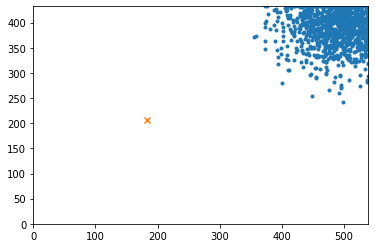

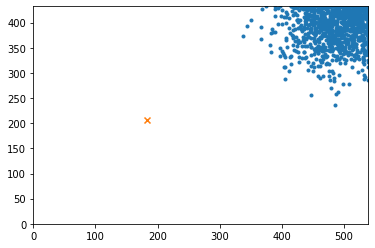

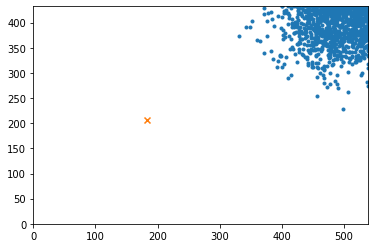

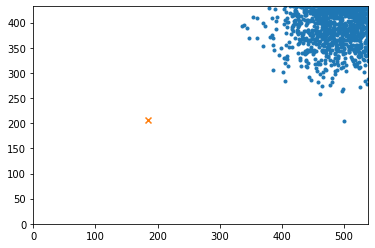

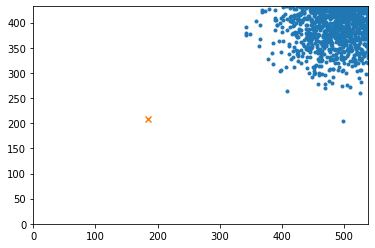

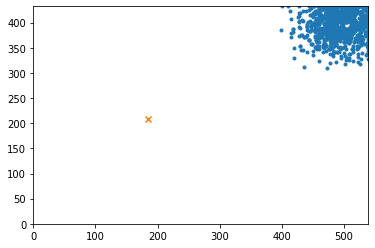

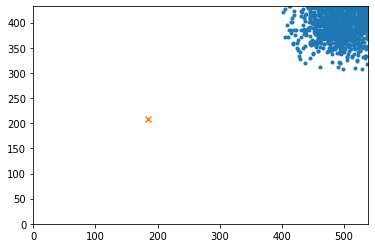

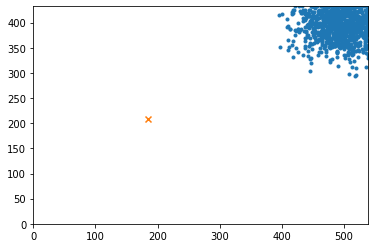

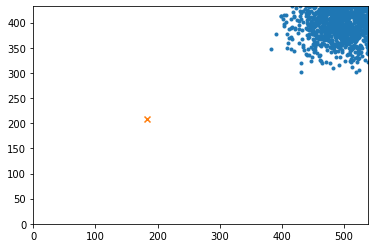

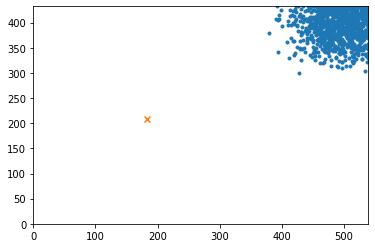

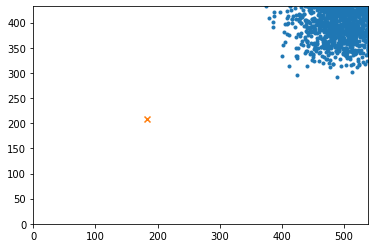

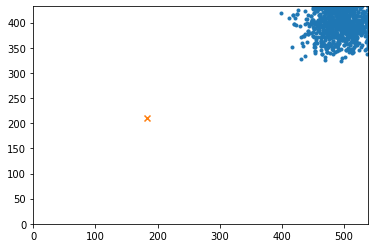

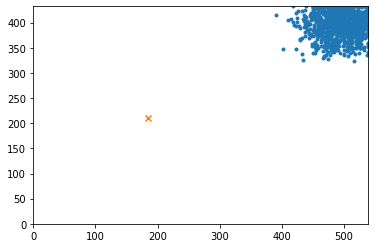

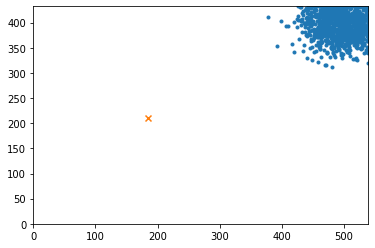

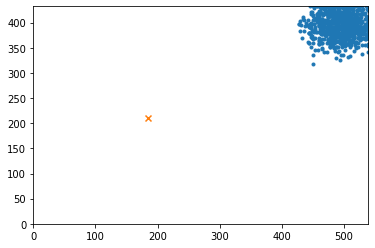

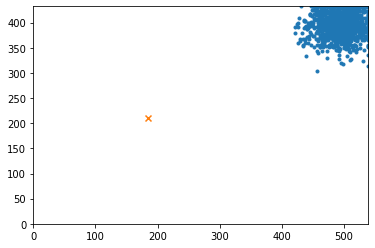

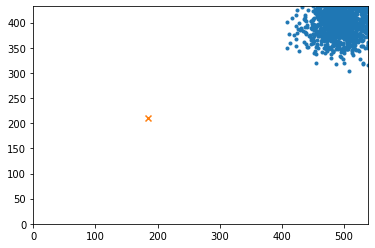

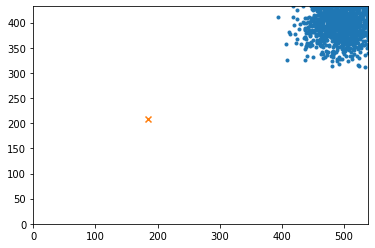

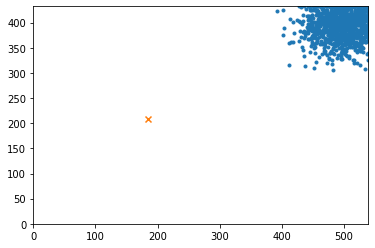

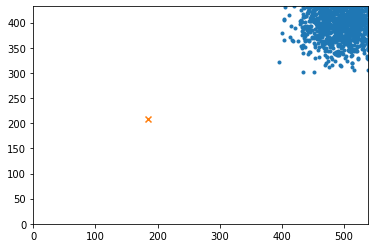

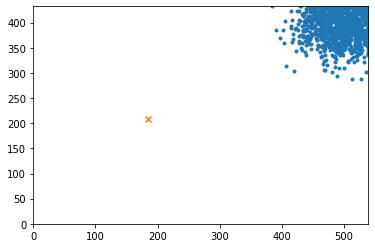

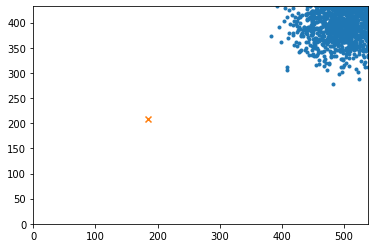

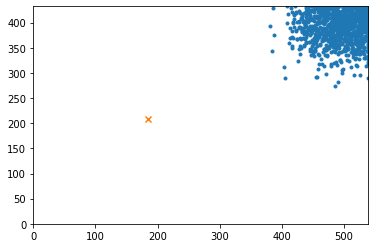

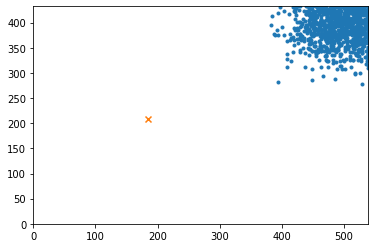

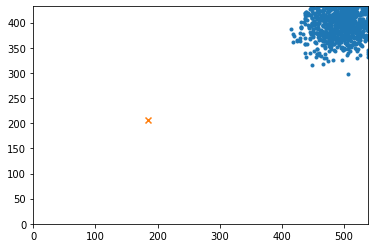

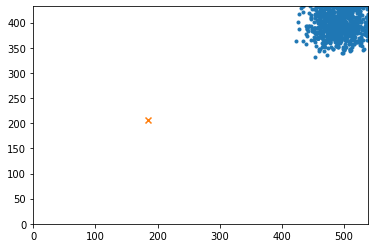

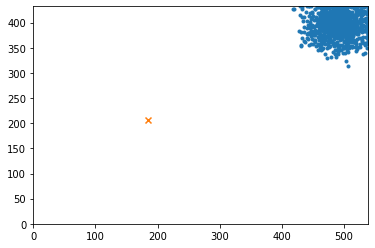

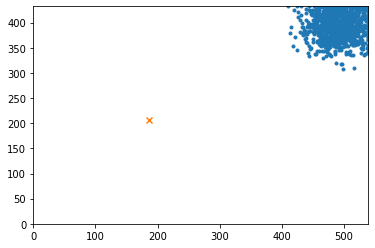

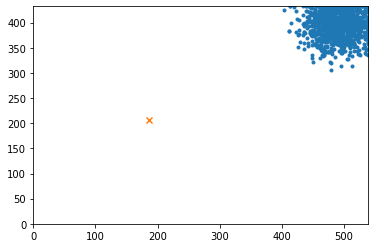

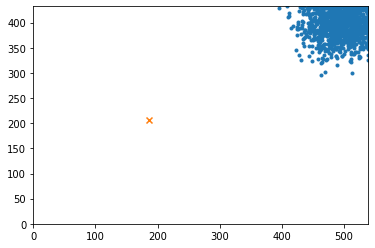

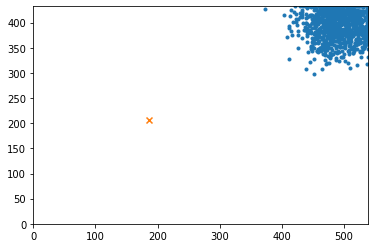

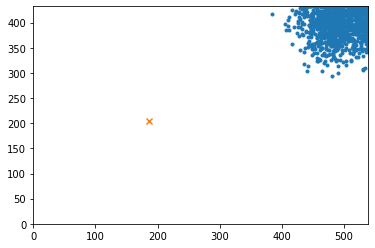

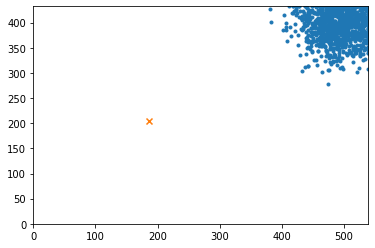

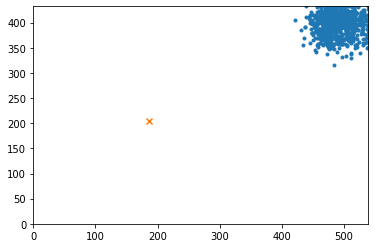

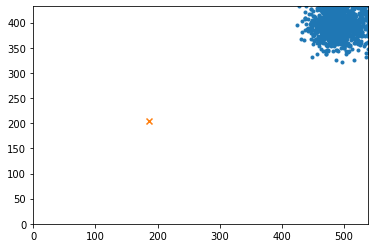

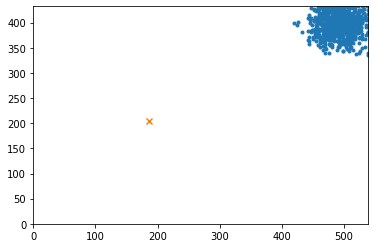

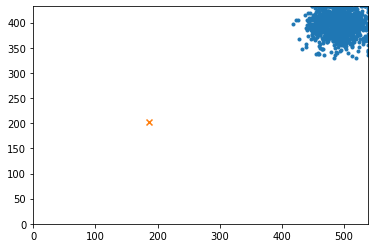

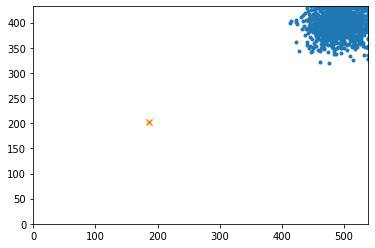

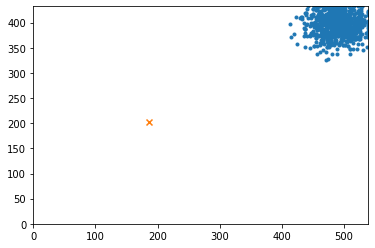

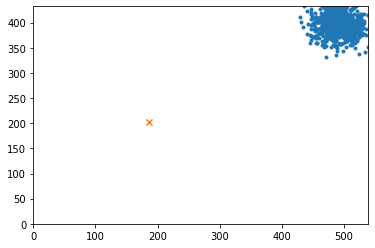

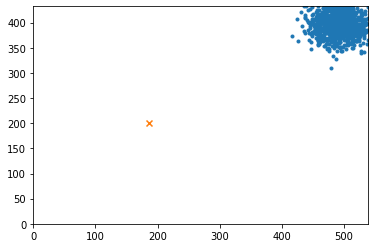

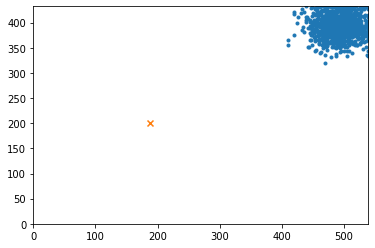

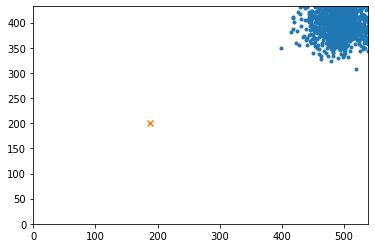

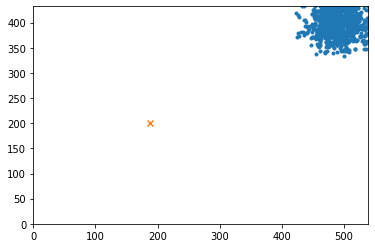

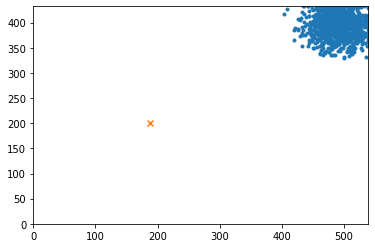

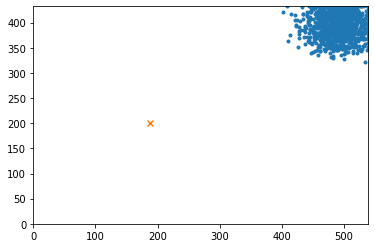

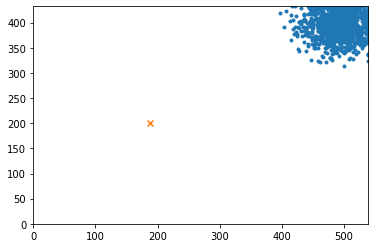

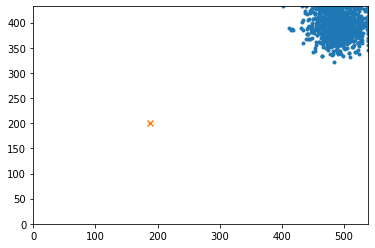

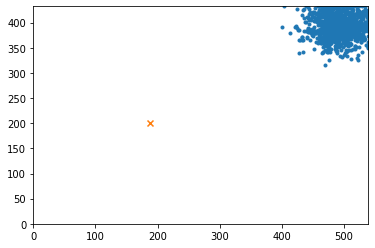

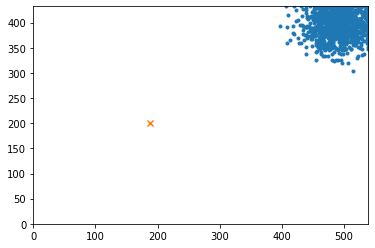

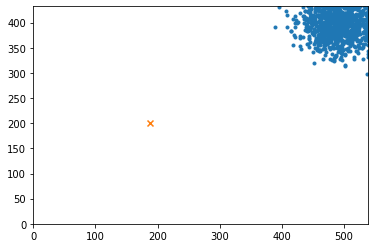

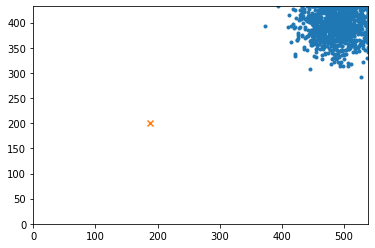

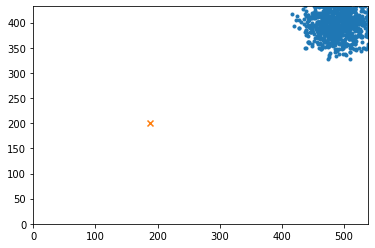

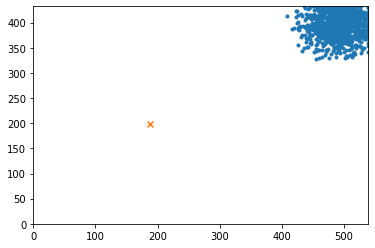

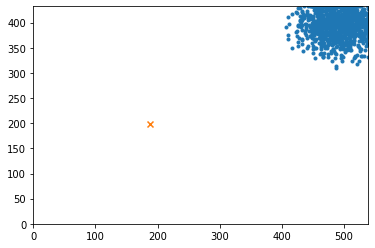

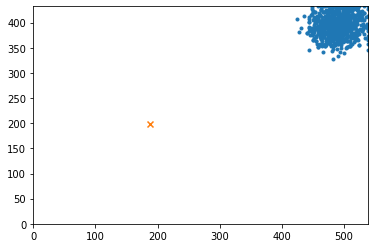

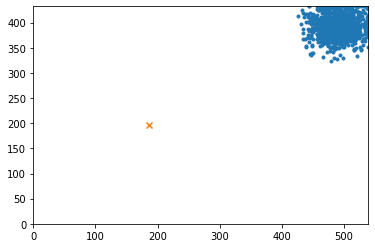

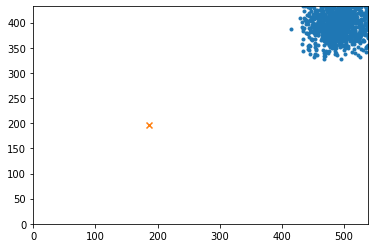

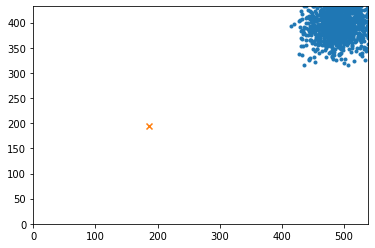

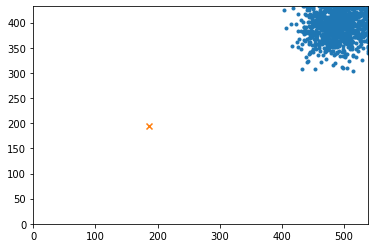

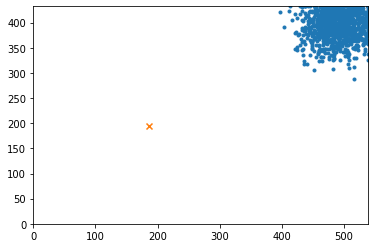

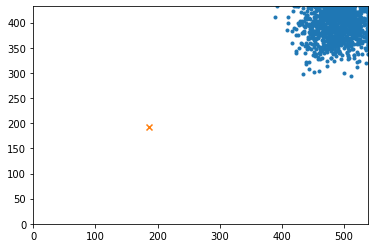

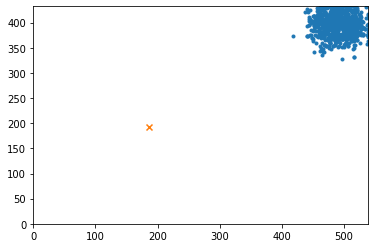

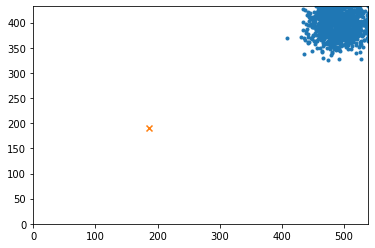

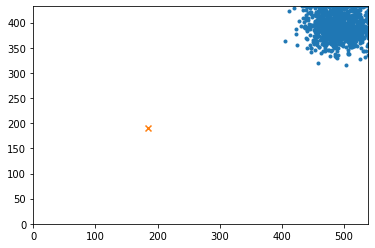

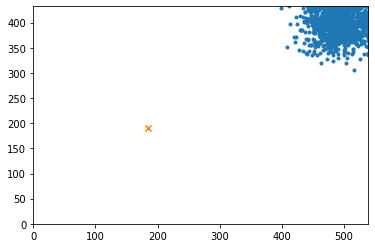

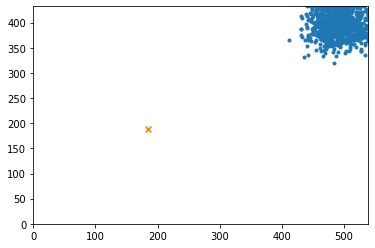

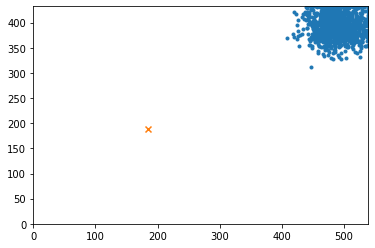

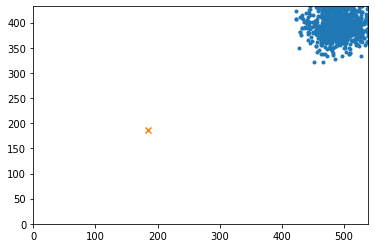

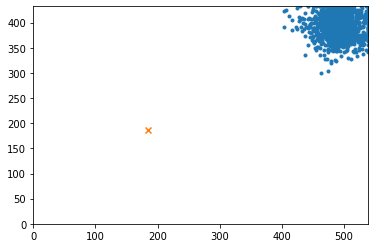

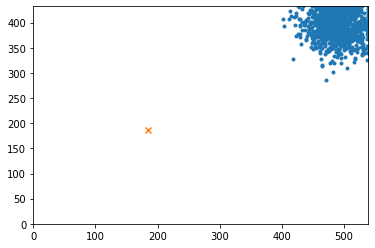

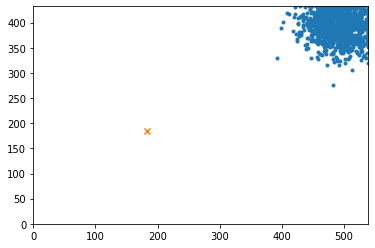

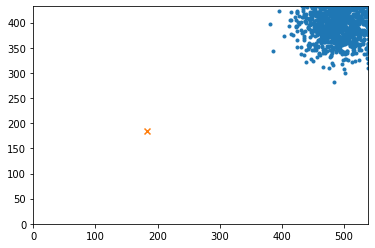

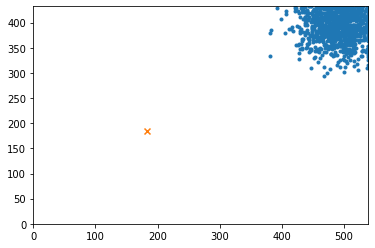

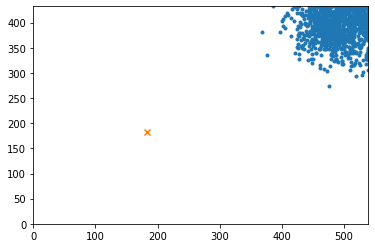

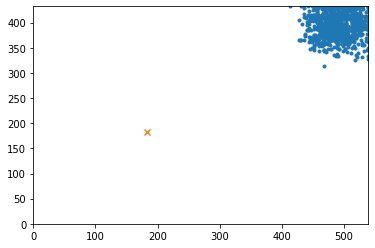

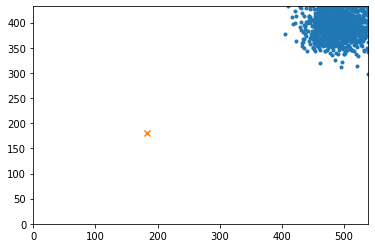

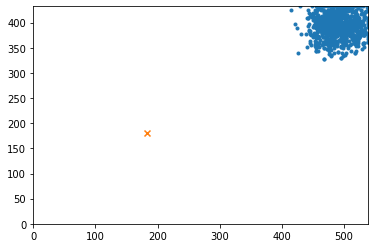

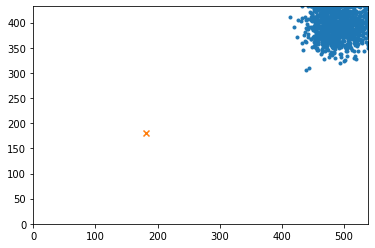

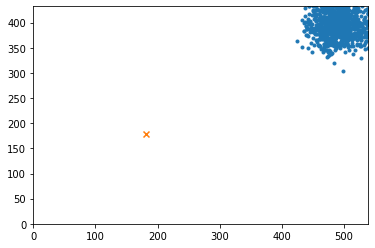

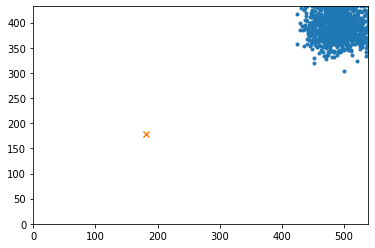

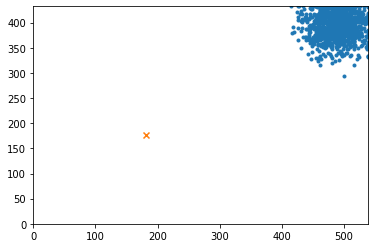

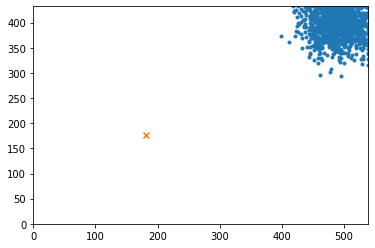

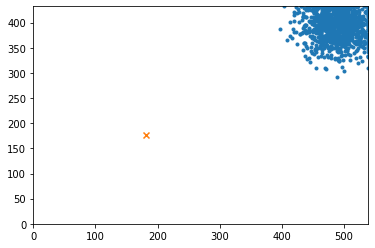

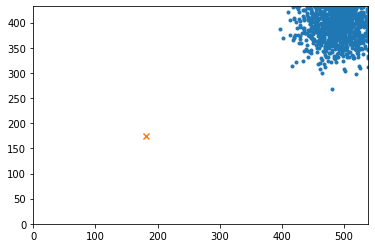

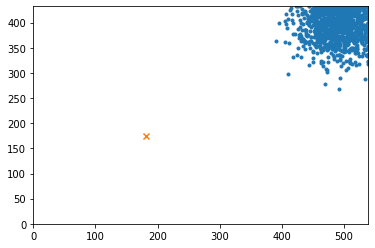

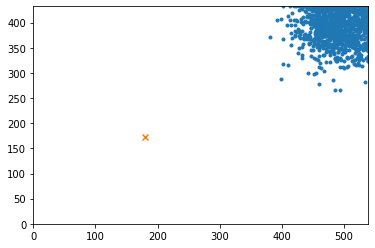

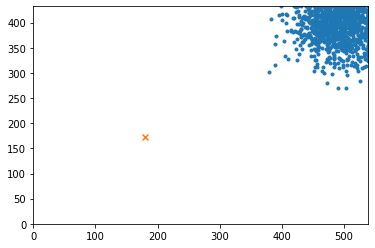

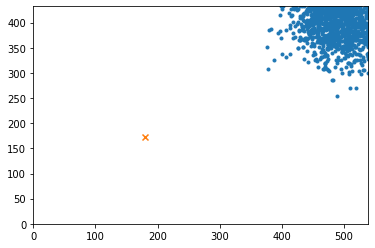

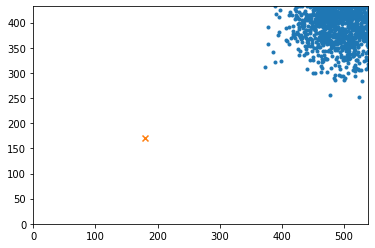

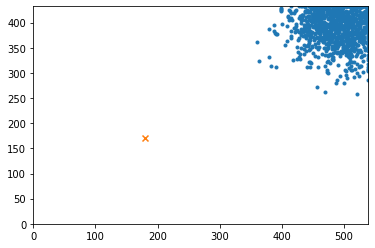

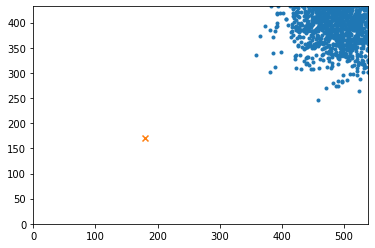

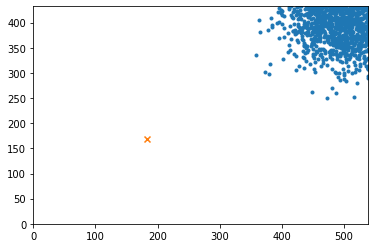

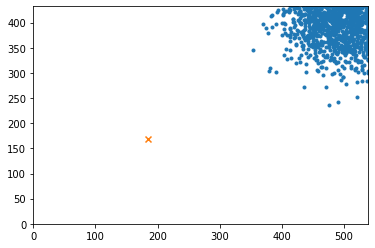

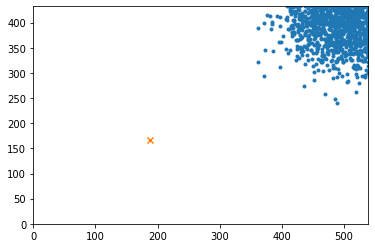

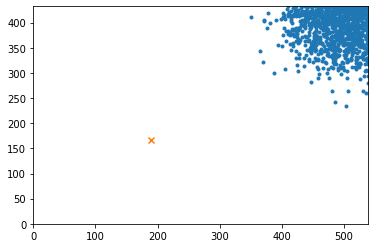

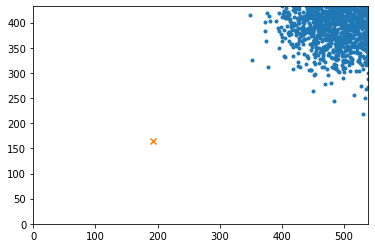

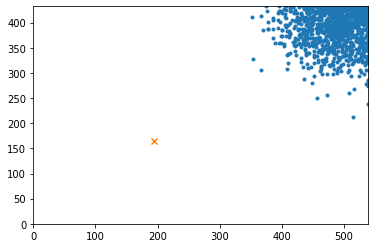

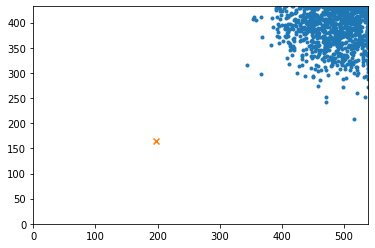

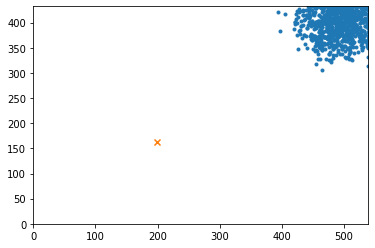

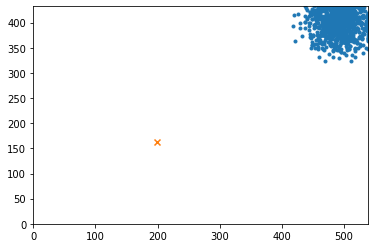

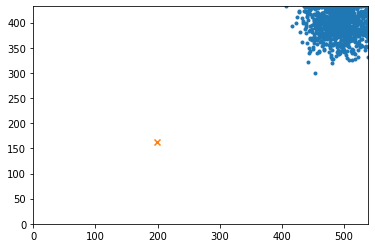

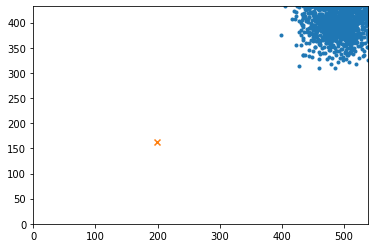

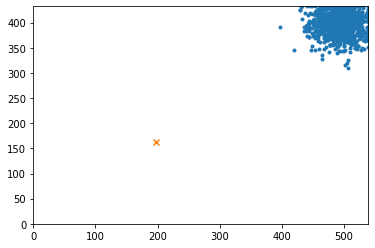

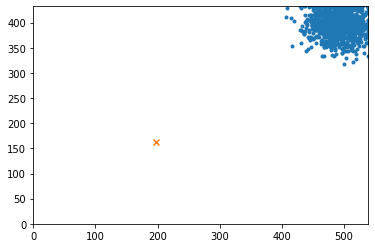

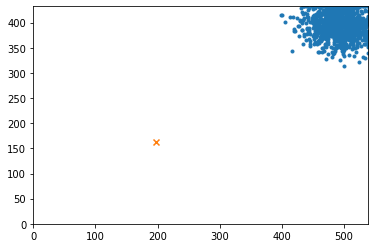

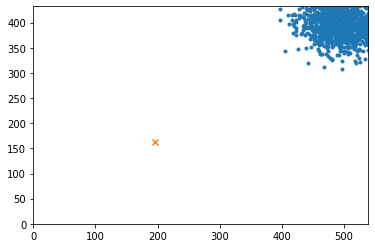

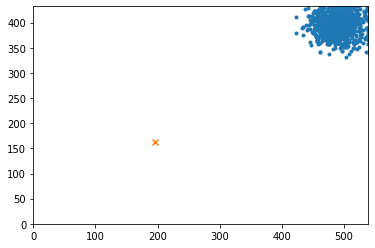

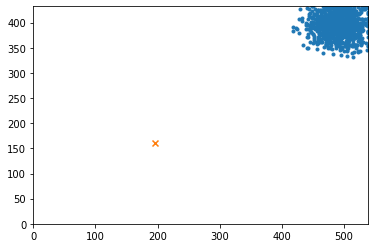

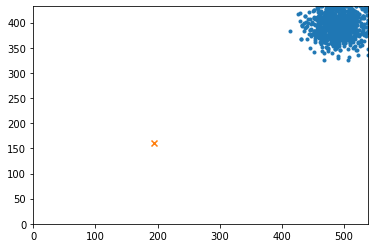

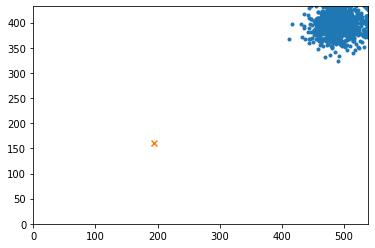

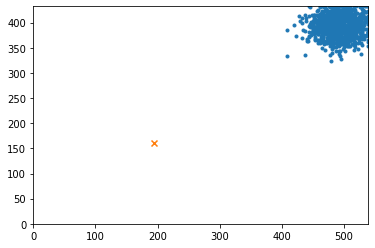

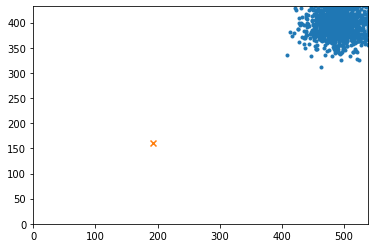

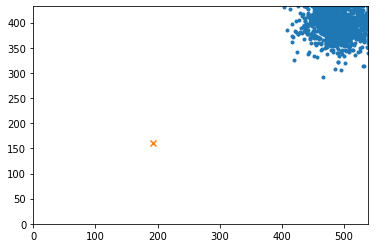

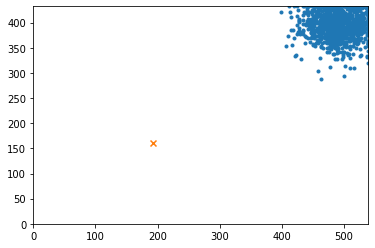

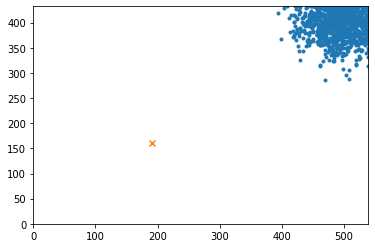

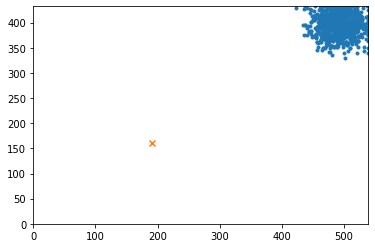

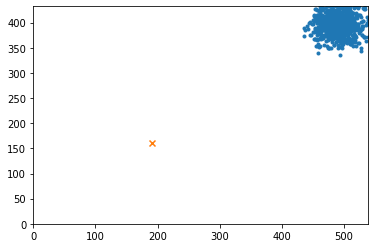

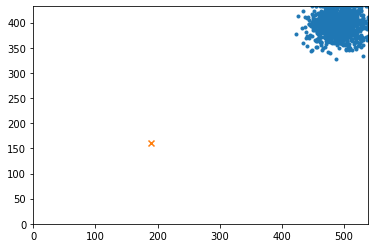

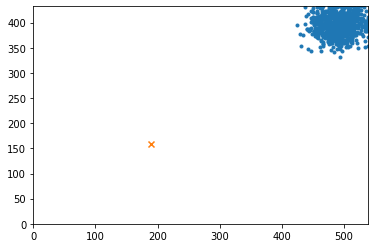

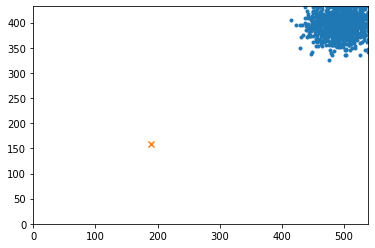

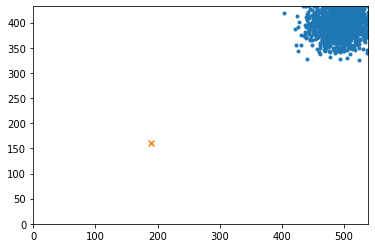

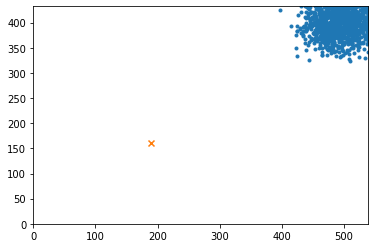

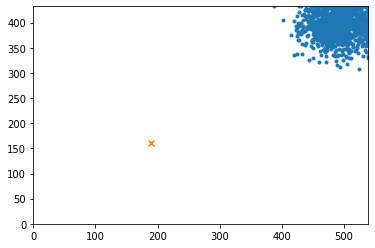

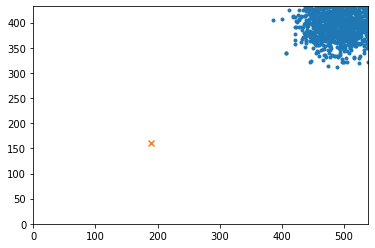

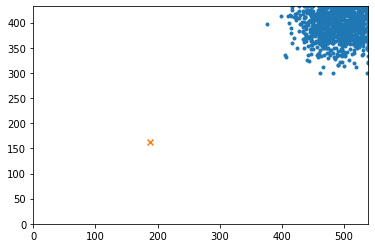

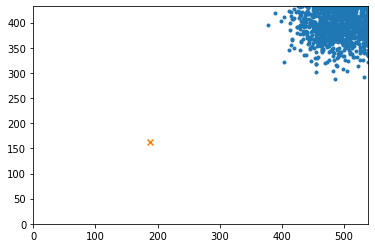

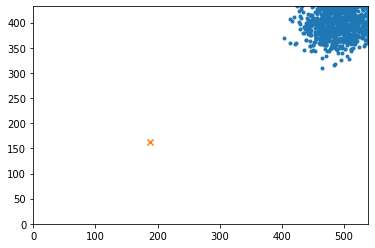

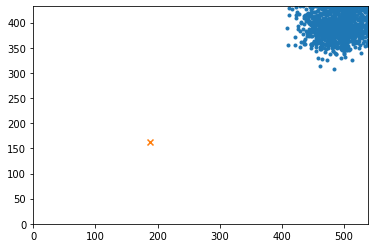

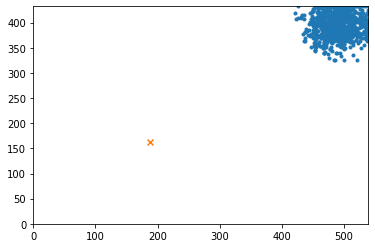

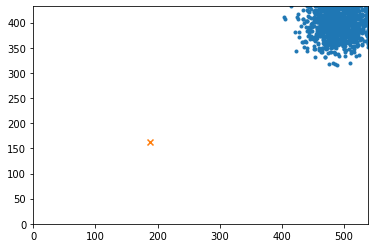

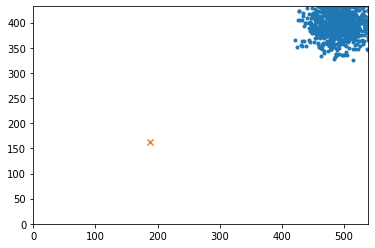

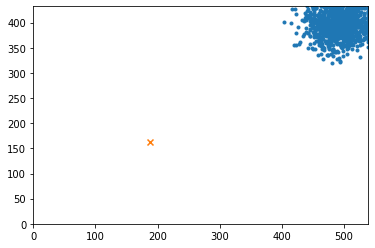

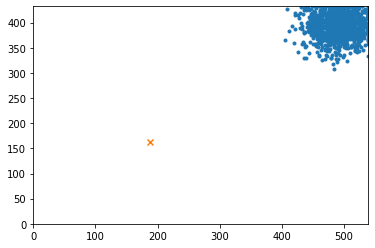

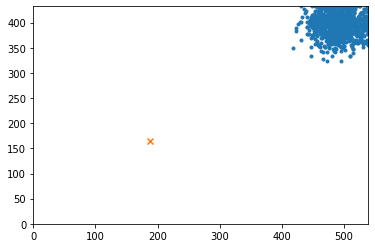

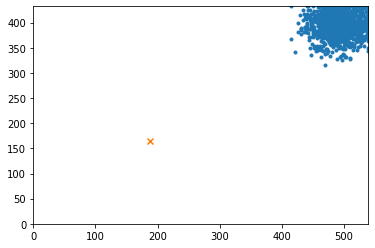

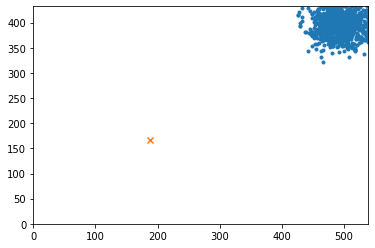

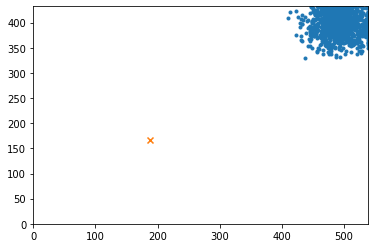

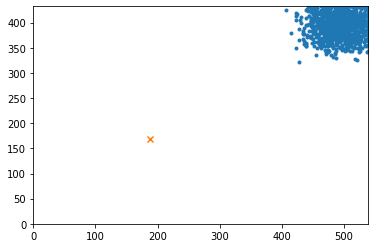

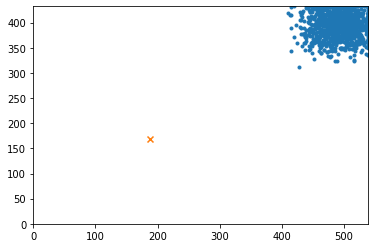

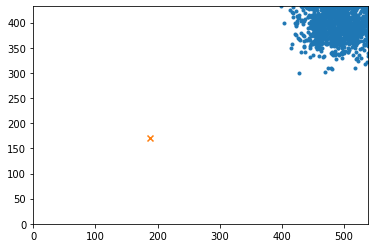

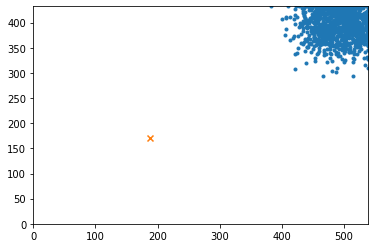

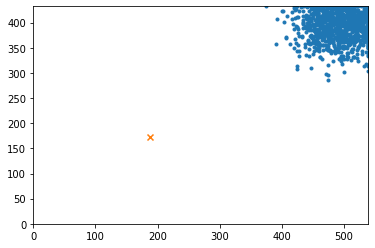

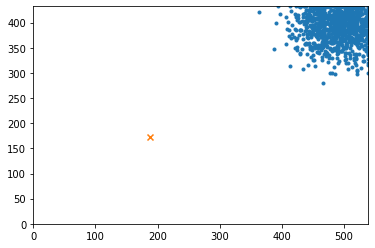

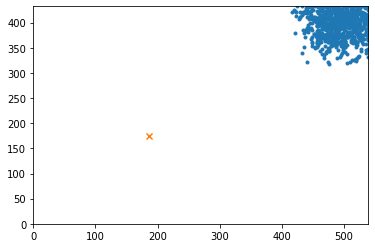

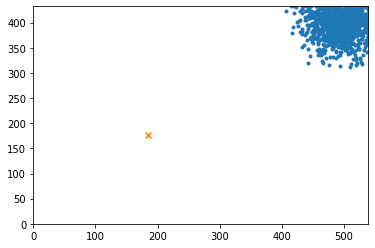

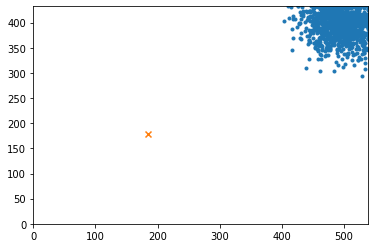

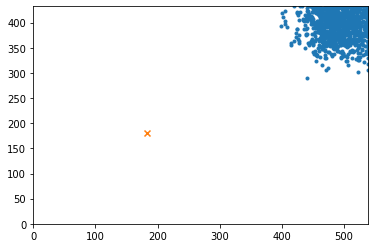

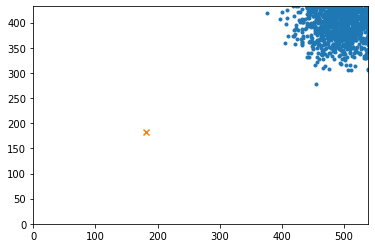

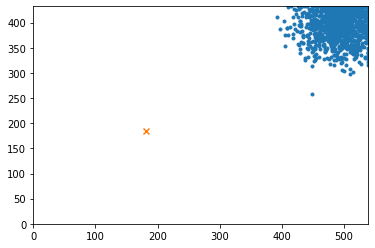

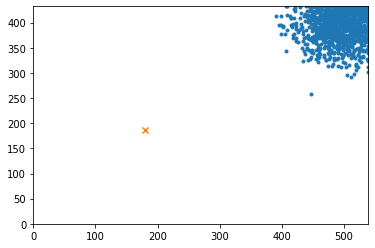

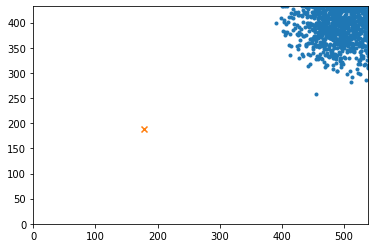

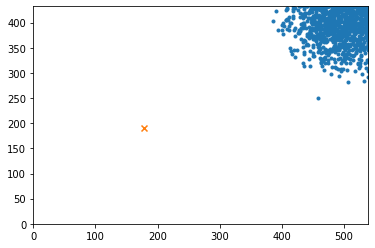

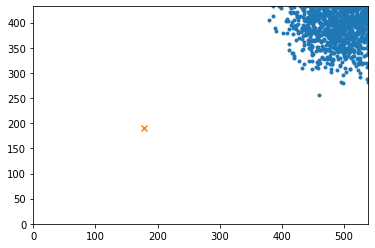

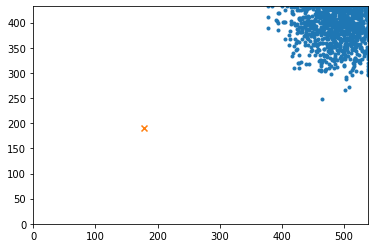

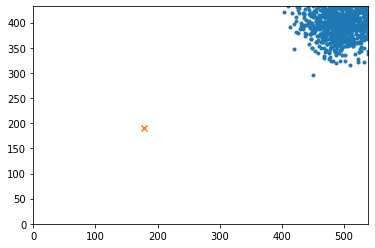

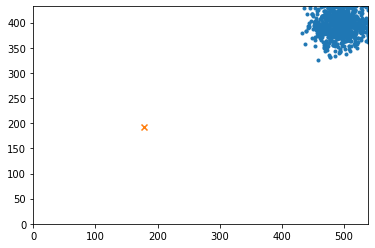

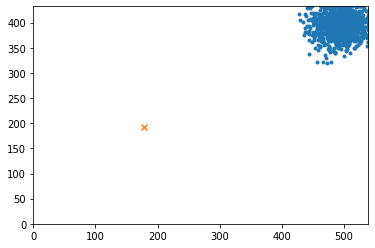

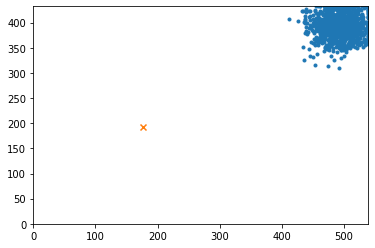

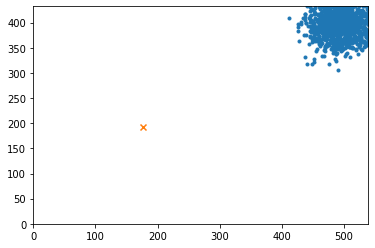

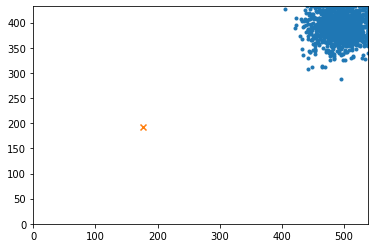

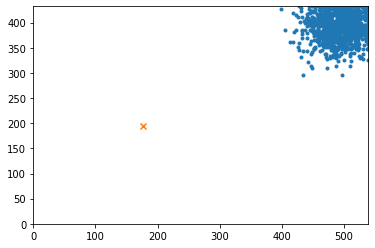

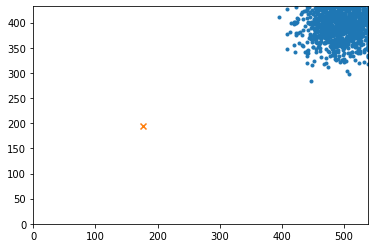

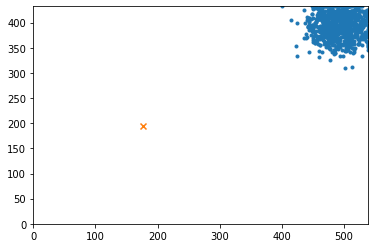

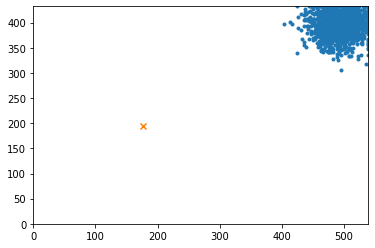

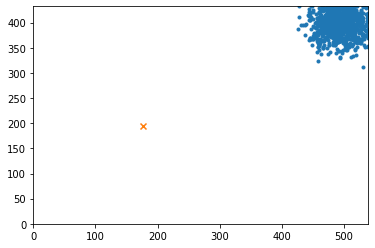

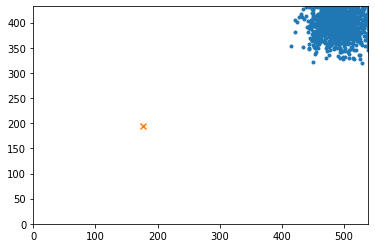

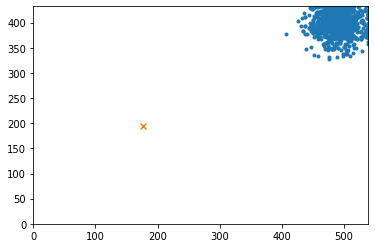

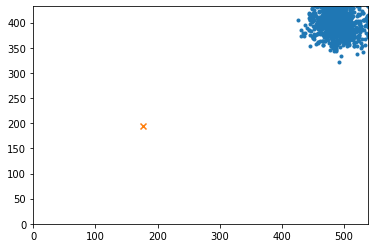

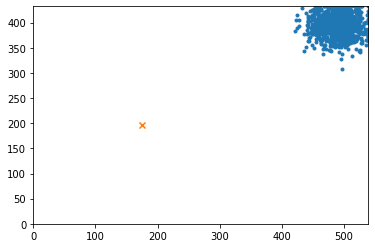

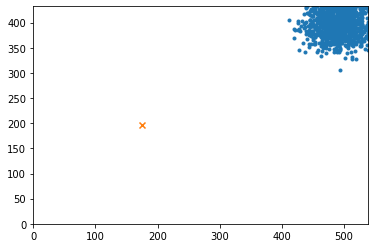

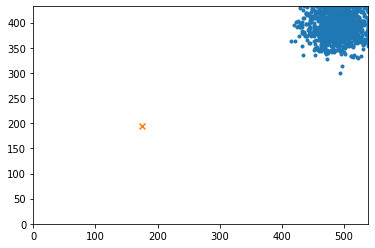

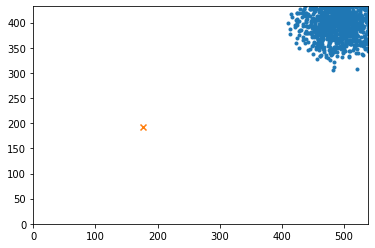

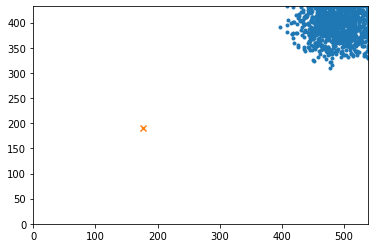

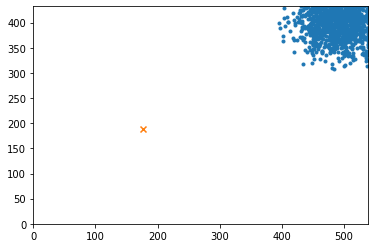

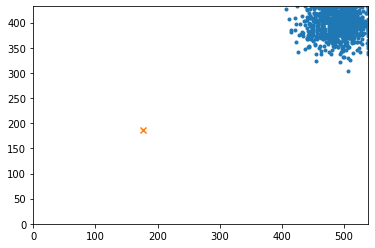

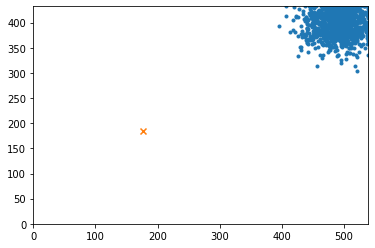

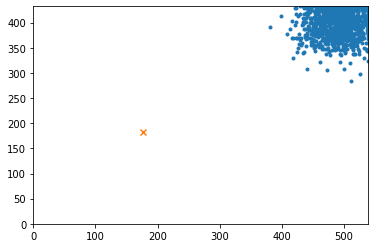

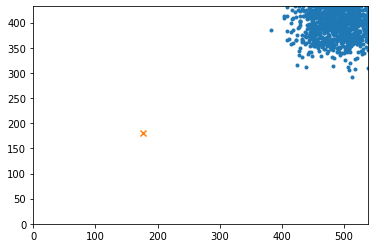

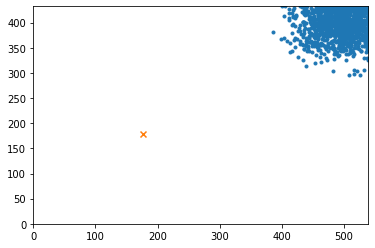

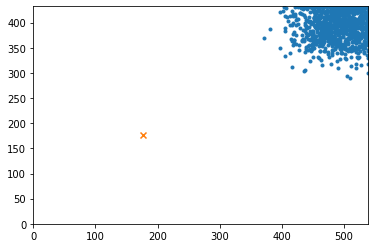

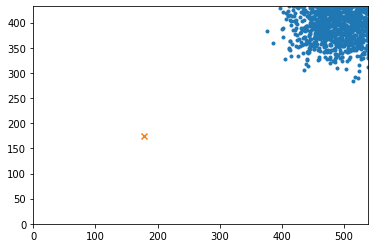

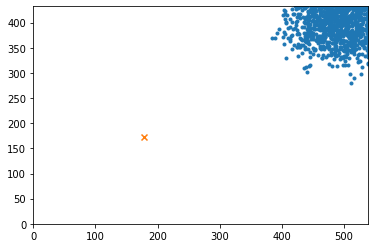

KeyboardInterrupt: 

In [73]:
pf = mdl.tracking.Particle_filter(2, np.array([[left_x, right_x], [bottom_y, top_y]]))

mu = np.array([rx_t[0], ry_t[0]])
std = np.array([50.0, 50.0])
sigma = np.array([10.0, 10.0])
pf.initialize(mu, std)

pos = np.empty((resamples, 2))
cov = np.empty((resamples, 2, 2))

plot_int = 1
for t in range(resamples):
    pf.update(eval_rate, rc_t[:, t], tbin)
    pf.predict(sigma)
    
    if pf.eff_cnt <= pf.sam_cnt/2:
        pf.resample()
    
    if t % plot_int == plot_int-1:
        plt.scatter(pf.samples[:, 0], pf.samples[:, 1], marker='.')
        plt.scatter(rx_t[t], ry_t[t], marker='x')
        plt.xlim(left_x, right_x)
        plt.ylim(bottom_y, top_y)
        plt.show()
        
    pos[t], cov[t] = pf.estimate()

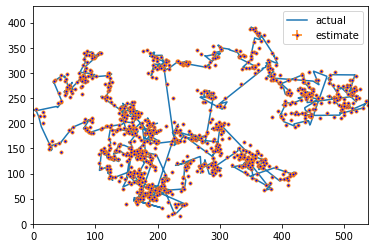

In [67]:
int_step = 10
step_plt = 10000
plt.plot(rx_t[0:step_plt], ry_t[0:step_plt], label='actual')
plt.xlim(left_x, right_x)
plt.ylim(bottom_y, top_y)
plt.errorbar(pos[0:step_plt:int_step, 0], pos[0:step_plt:int_step, 1], \
             xerr=np.sqrt(cov[0:step_plt:int_step, 0, 0]), yerr=np.sqrt(cov[0:step_plt:int_step, 1, 1]), \
             marker='.', markerfacecolor='b', linestyle='', label='estimate')
plt.legend()
plt.show()

In [ ]:
_, _, spikes, _ = neural_utils.BinTrain(1, sample_bin, syn_t_spike, steps)
tools.raster_plot((10, 10), spikes, steps, sample_bin*1000, neurons, markersize=100)
plt.show()

### Dimensionality reduction

In [4]:
### Real data ###
sample_bin, track_samples, x_t, y_t, s_t, dir_t, hd_t, eeg_t, theta_t, \
    hilbert_amp, hilbert_theta, pause_ind, pause_size, \
    sep_t_spike, clu_id, t_spike, spike_samples, units, \
    shank_id, local_clu, FR_waveshape, SpkWidthC, \
    refract_viol, sess_avg_rate, isolation_dist, LV, ISI, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('./saves/datasets/hc5_13.p', 'rb'))

max_speed = s_t.max()
wrap_theta_t = tools.WrapPi(theta_t, True)
arena_width = right_x - left_x
arena_height = top_y - bottom_y

grid_size = (int(arena_width/2), int(arena_height/2))
grid_shape = (left_x, right_x, bottom_y, top_y)

In [17]:
# Fit to subset of neurons
unit_used = np.arange(50)
units_used = len(unit_used)
used_t_spike = [sep_t_spike[u] for u in unit_used]
behav_data = (x_t, y_t, wrap_theta_t)

bin_size = 500
tbin, resamples, rc_t, (rx_t, ry_t, rtheta_t) = neural_utils.BinTrain(bin_size, sample_bin, used_t_spike, 
                                                                    track_samples, behav_data)



# smoothing of spike train into rate, timescale can capture or average theta
#neural_utils.smooth_hist

(50, 7595)


In [18]:
# Perform Laplacian eigenmap
from sklearn.manifold import SpectralEmbedding


embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(rc_t.T)




# Visualize and fit parametric mapping to perform dimensionality reduction

In [23]:
print(X_transformed.shape)

(7595, 2)


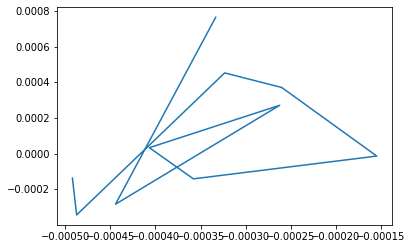

In [25]:
plt.plot(X_transformed[:10, 0], X_transformed[:10, 1])

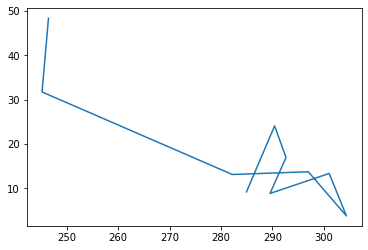

In [26]:
plt.plot(rx_t[:10], ry_t[:10])